In [ ]:
!wget https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-machine-learning-challenge-pet-adoption/pet-adoption-9-5838c75b/a01c26dcd27711ea.zip

--2020-08-19 06:35:47--  https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-machine-learning-challenge-pet-adoption/pet-adoption-9-5838c75b/a01c26dcd27711ea.zip
Resolving he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)... 52.219.40.52
Connecting to he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)|52.219.40.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534157 (522K) [application/zip]
Saving to: ‘a01c26dcd27711ea.zip’

a01c26dcd27711ea.zi 100%[===================>] 521.64K   114KB/s    in 5.0s    

2020-08-19 06:35:52 (104 KB/s) - ‘a01c26dcd27711ea.zip’ saved [534157/534157]



In [ ]:
!unzip a01c26dcd27711ea.zip

Archive:  a01c26dcd27711ea.zip
   creating: Dataset/
  inflating: Dataset/train.csv       
  inflating: Dataset/test.csv        


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install rfpimp
!pip install catboost
from sklearn.metrics import mean_absolute_error,accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split,StratifiedShuffleSplit
from rfpimp import *
from tqdm import tqdm
from catboost import *
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 163kB 4.5MB/s 
  Created wheel for rfpimp: filename=rfpimp-1.3.5-cp36-none-any.whl size=10260 sha256=07aaa0ff8fdbfc07b36ed98a4b266d0a659eaacd2df17791c0630f6cbc0d48d2
  Stored in directory: /root/.cache/pip/wheels/2a/c8/bf/80f91224be00870f84a85aa1782cf6cd62c1289a173b66b8e9
  Created wheel for stratx: filename=stratx-0.4.1-cp36-none-any.whl size=35079 sha256=b0277ade98c40234ff54ec13e4eef827261d358b1e31130feca9322c9c305fe0
  Stored in directory: /root/.cache/pip/wheels/ca/c1/e1/3e4c41e3420fe9c706dd4d8ef8d7fb5aba1b6a9547649a2d00
Successfully built rfpimp stratx
     |████████████████████████████████| 65.9MB 56kB/s 


In [ ]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

In [ ]:
train.head(5)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [ ]:
test.head(5)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2
0,ANSL_75005,2005-08-17 00:00:00,2017-09-07 15:35:00,0.0,Black,0.87,42.73,0,7
1,ANSL_76663,2018-11-15 00:00:00,2019-05-08 17:24:00,1.0,Orange Tabby,0.06,6.71,0,1
2,ANSL_58259,2012-10-11 00:00:00,2018-04-02 16:51:00,1.0,Black,0.24,41.21,0,7
3,ANSL_67171,2015-02-13 00:00:00,2018-04-06 07:25:00,1.0,Black,0.29,8.46,7,1
4,ANSL_72871,2017-01-18 00:00:00,2018-04-26 13:42:00,1.0,Brown,0.71,30.92,0,7


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(pet_id               0
 issue_date           0
 listing_date         0
 condition         1477
 color_type           0
 length(m)            0
 height(cm)           0
 X1                   0
 X2                   0
 breed_category       0
 pet_category         0
 dtype: int64, pet_id            0
 issue_date        0
 listing_date      0
 condition       619
 color_type        0
 length(m)         0
 height(cm)        0
 X1                0
 X2                0
 dtype: int64, (18834, 11), (8072, 9), pet_id             object
 issue_date         object
 listing_date       object
 condition         float64
 color_type         object
 length(m)         float64
 height(cm)        float64
 X1                  int64
 X2                  int64
 breed_category    float64
 pet_category        int64
 dtype: object)

In [ ]:
df=pd.concat([train,test])
#df=train.append(test,ignore_index=True)

In [ ]:
#df['pet_id']=df.pet_id.str.extract('(\d+)').astype(int)

In [ ]:
k=['issue_date','listing_date']
for i in k:
  df[i] = pd.to_datetime(df[i])
df['diff']=df['listing_date']-df['issue_date']
df['diff']=abs(df['diff'].astype(int))/1000000000000

In [ ]:
k=['issue_date','listing_date']
for i in k:
  df[i+'_'+'year'] = df[i].dt.year
  df[i+'_'+'day'] = df[i].dt.day
  df[i+'_'+'weekofyear'] = df[i].dt.weekofyear
  df[i+'_'+'month'] = df[i].dt.month
  df[i+'_'+'dayofweek'] =df[i].dt.dayofweek
  df[i+'_'+'weekend'] = (df[i].dt.weekday >=5).astype(int)
  df[i+'_'+'hour'] = df[i].dt.hour
  df[i+'_'+'minute'] = df[i].dt.minute
for i in k:
  del df[i]

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["col_cond"] = df["condition"].fillna('-9999').astype(str)+"_"+df["color_type"]
df["col_cond"] = le.fit_transform(df["col_cond"])

In [ ]:
df['condition']=df['condition'].fillna(3.0)
df['condition']=df['condition']+1
#df['condition']=df['condition'].fillna(method='bfill')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['color_type'] = le.fit_transform(df['color_type'])
le.classes_

array(['Agouti', 'Apricot', 'Black', 'Black Brindle', 'Black Smoke',
       'Black Tabby', 'Black Tiger', 'Blue', 'Blue Cream', 'Blue Merle',
       'Blue Point', 'Blue Smoke', 'Blue Tabby', 'Blue Tick',
       'Blue Tiger', 'Brown', 'Brown Brindle', 'Brown Merle',
       'Brown Tabby', 'Brown Tiger', 'Buff', 'Calico', 'Calico Point',
       'Chocolate', 'Chocolate Point', 'Cream', 'Cream Tabby', 'Fawn',
       'Flame Point', 'Gold', 'Gray', 'Gray Tabby', 'Green',
       'Lilac Point', 'Liver', 'Liver Tick', 'Lynx Point', 'Orange',
       'Orange Tabby', 'Pink', 'Red', 'Red Merle', 'Red Tick', 'Sable',
       'Seal Point', 'Silver', 'Silver Lynx Point', 'Silver Tabby', 'Tan',
       'Torbie', 'Tortie', 'Tortie Point', 'Tricolor', 'White', 'Yellow',
       'Yellow Brindle'], dtype=object)

In [ ]:
#extraa
import math
df['length(m)']=df['length(m)']*100
df['area']=(df['height(cm)']*df['length(m)'])+(df['X1']+df['X2'])
#df['val']=df['height(cm)']*df['length(m)']*2*math.pi
df['Ag_x']=df['color_type']*df['condition']
df['Ag_y']=df['condition']*df['X1']
df['Ag_z']=df['condition']*df['X2']
m=(df['issue_date_year'].min())-1
df['Ag_a']=(df['issue_date_year']-m)*df['color_type']
df['Ag_b']=(df['issue_date_year']-m)*df['condition']
df["X12col"] = df["X1"]+df["X2"] + df["col_cond"]
#df['power']=df['diff']/(df['Ag_a']*(df['color_type']+df['condition']))#new
#df['xor']=df['diff']/(df['X1']*df['condition'])#new

In [ ]:
temp = df.groupby(['color_type']).agg({'X1':['count','mean','sum','median'], #median
                                            'X2':['count','mean','sum'],#median
                                       #'X12col':['count','mean','sum','median'],#new
                                       #'diff':['count','mean','sum','median'], #new
                                   #'length(m)':['count','sum','min','max','mean'],
                                   #'height(cm)':['count','sum','min','max','mean'],
                                   #'issue_date_weekofyear':['min','max','count'],
                                   #'issue_date_day':['min','max','count'],
                                   #'listing_date_weekofyear':['min','max','count'],
                                   'condition':['count','mean',],#median
                                       'color_type':['count','mean','sum']})
temp.columns = ['_'.join(x) for x in temp.columns]
df = pd.merge(df,temp,on=['color_type'],how='left')

In [ ]:
temp = df.groupby(['condition']).agg({
                                       'color_type':['count','sum','mean','max'],
                                      #'X1':['count','mean','sum','median'],
                                      #'X2':['count','mean','sum','median']
                                      })
temp.columns = ['_condd_'.join(x) for x in temp.columns]
df = pd.merge(df,temp,on=['condition'],how='left')

In [ ]:
df = pd.get_dummies(df, columns=['condition','color_type','X1','X2'])
del df['issue_date_hour']
del df['issue_date_minute']

In [ ]:
train = df[df['breed_category'].isnull()==False]
test = df[df['breed_category'].isnull()==True]
del test['breed_category']
del test['pet_category']


In [ ]:
train_df=train.copy()
test_df=test.copy()

# F2

In [ ]:
from math import sqrt 
from sklearn.metrics import f1_score

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
x=train_df['pet_category']
del train_df['pet_category']
index=test_df['pet_id']
del train_df['pet_id']
del test_df['pet_id']

In [ ]:
X = train_df.drop(labels=['breed_category'], axis=1)
y = train_df['breed_category'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=101)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((16950, 131), (16950,), (1884, 131), (1884,))

In [ ]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([], dtype=int64)

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=3,
                         depth=10,
                         random_seed=121, 
                         iterations=3500, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
cat.fit(X_train, y_train, verbose=100,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)
predictions = cat.predict(X_cv)
print('accuracy:', f1_score(y_cv, predictions, average='weighted'))

0:	learn: 0.8955009	test: 0.8955009	test1: 0.8945827	best: 0.8945827 (0)	total: 29ms	remaining: 1m 41s
100:	learn: 0.9856586	test: 0.9856586	test1: 0.9080819	best: 0.9112767 (87)	total: 14.6s	remaining: 8m 11s
200:	learn: 0.9991740	test: 0.9991740	test1: 0.9112960	best: 0.9155666 (189)	total: 29.7s	remaining: 8m 7s
300:	learn: 1.0000000	test: 1.0000000	test1: 0.9123853	best: 0.9155666 (189)	total: 45s	remaining: 7m 58s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.9097278	best: 0.9155666 (189)	total: 1m	remaining: 7m 45s
500:	learn: 1.0000000	test: 1.0000000	test1: 0.9086844	best: 0.9155666 (189)	total: 1m 15s	remaining: 7m 31s
600:	learn: 1.0000000	test: 1.0000000	test1: 0.9065517	best: 0.9155666 (189)	total: 1m 30s	remaining: 7m 17s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.9155665504
bestIteration = 189

Shrink model to first 190 iterations.
accuracy: 0.9155665503517817


In [ ]:
print('accuracy:', f1_score(y_cv, predictions, average='weighted'))

accuracy: 0.9155665503517817


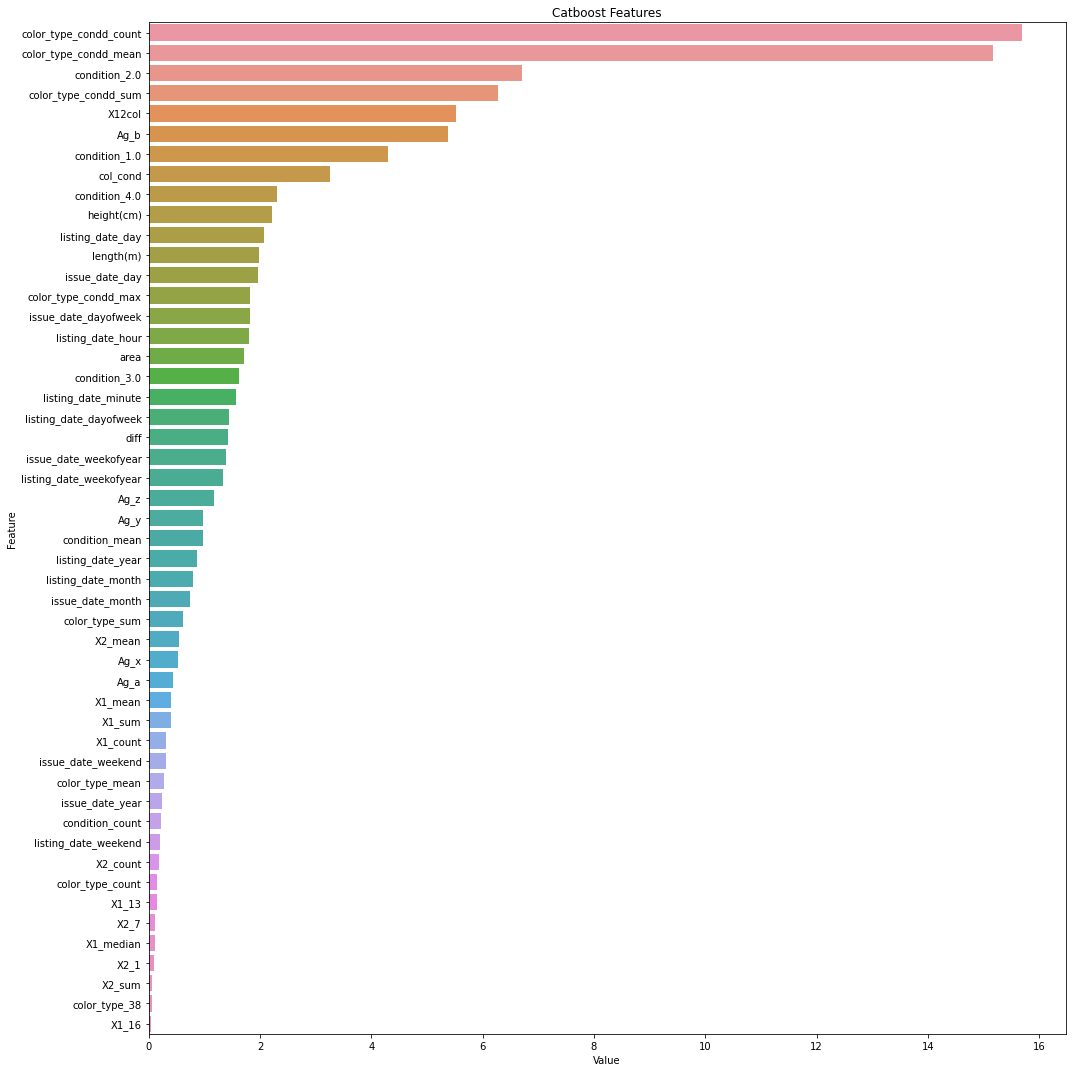

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=3,
                         depth=6,
                         random_seed=121, 
                         iterations=3500, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=0.8, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", f1_score(y_test,y_pred_cat, average='weighted'))

    errcat.append(f1_score(y_test,y_pred_cat, average='weighted'))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

Accuracy:  0.9143785822178329
Accuracy:  0.9180032801437995
Accuracy:  0.9011008349216595
Accuracy:  0.9095629136529935
Accuracy:  0.907065237138088
Accuracy:  0.8973570727782884
Accuracy:  0.9198326016193012
Accuracy:  0.9131980655052933
Accuracy:  0.9052955696381942


In [ ]:
np.mean(errcat,0)

0.9102389415278752

In [ ]:
cat_final = np.mean(y_pred_totcat,0).round().astype(int)
cat_final

array([[1],
       [0],
       [0],
       ...,
       [1],
       [2],
       [1]])

In [ ]:
xxx = pd.DataFrame(data=cat_final, columns=['breed_category'])

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['pet_category'] = le.fit_transform(train_df['pet_category'])
le.classes_

array([0., 1., 2., 4.])

In [ ]:
x=train_df['breed_category']
del train_df['breed_category']
index=test_df['pet_id']
del train_df['pet_id']
del test_df['pet_id']

In [ ]:
X = train_df.drop(labels=['pet_category'], axis=1)
y = train_df['pet_category'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=101)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((16950, 131), (16950,), (1884, 131), (1884,))

In [ ]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([], dtype=int64)

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=4,
                         depth=6,
                         random_seed=42, 
                         iterations=3500, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=0.8, 
                         random_strength=1,
                         #od_pval=0.00001,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
cat.fit(X_train, y_train, verbose=100,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)

0:	learn: 0.8637483	test: 0.8637483	test1: 0.8787213	best: 0.8787213 (0)	total: 31.9ms	remaining: 1m 51s
100:	learn: 0.9094773	test: 0.9094773	test1: 0.9077795	best: 0.9088443 (97)	total: 3.08s	remaining: 1m 43s
200:	learn: 0.9249801	test: 0.9249801	test1: 0.9109738	best: 0.9125606 (142)	total: 6.15s	remaining: 1m 40s
300:	learn: 0.9351372	test: 0.9351372	test1: 0.9110154	best: 0.9126015 (293)	total: 9.2s	remaining: 1m 37s
400:	learn: 0.9457747	test: 0.9457747	test1: 0.9141811	best: 0.9141811 (377)	total: 12.3s	remaining: 1m 35s
500:	learn: 0.9543626	test: 0.9543626	test1: 0.9147369	best: 0.9157891 (484)	total: 15.4s	remaining: 1m 32s
600:	learn: 0.9628670	test: 0.9628670	test1: 0.9147551	best: 0.9168525 (518)	total: 18.4s	remaining: 1m 28s
700:	learn: 0.9699393	test: 0.9699393	test1: 0.9152775	best: 0.9168525 (518)	total: 21.4s	remaining: 1m 25s
800:	learn: 0.9749779	test: 0.9749779	test1: 0.9120876	best: 0.9168525 (518)	total: 24.5s	remaining: 1m 22s
900:	learn: 0.9801946	test: 0.980

In [ ]:
predictions = cat.predict(X_cv)
print('accuracy:', f1_score(y_cv, predictions, average='weighted'))

accuracy: 0.9168525248820393


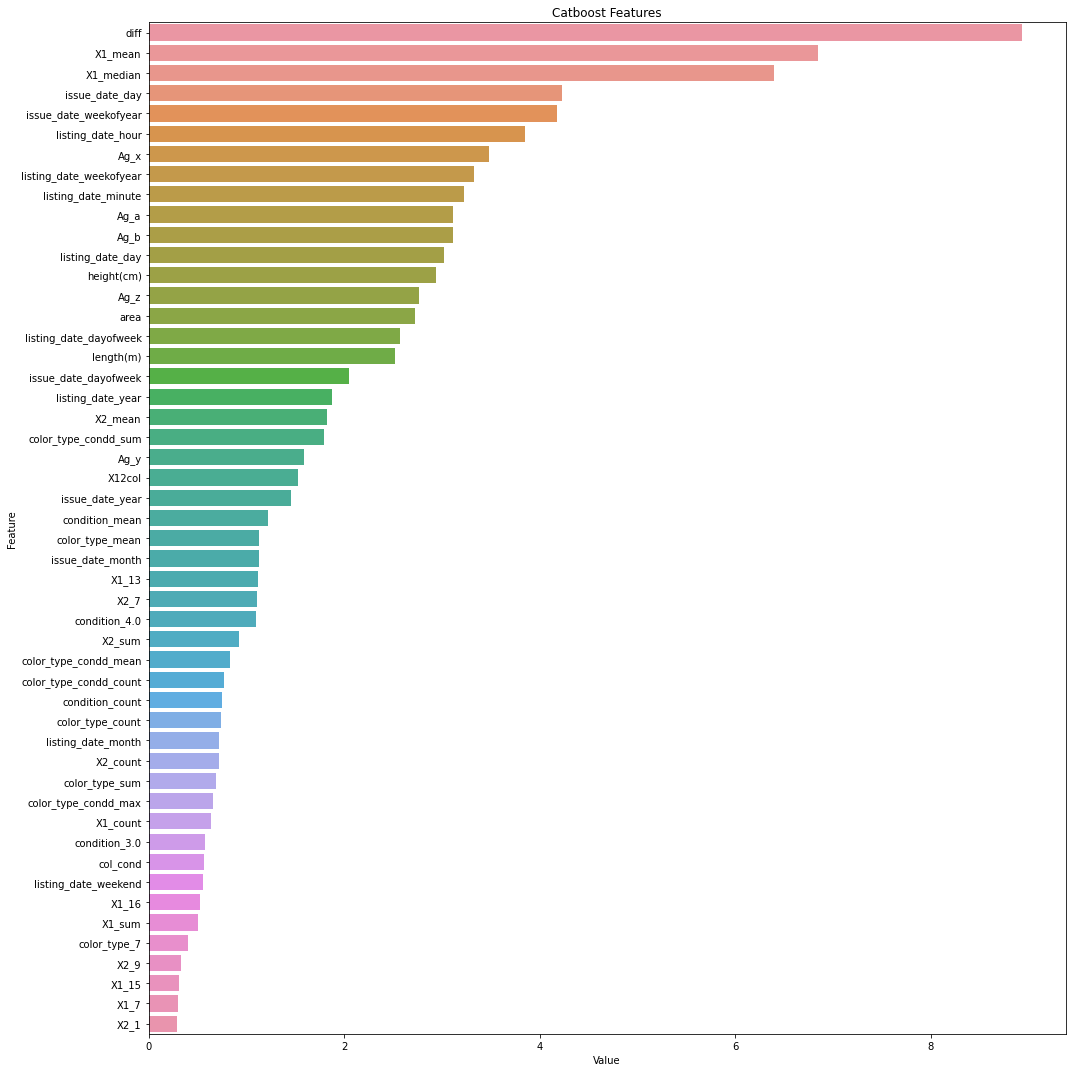

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=4,
                         depth=6,
                         random_seed=42, 
                         iterations=3500, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=0.8, 
                         random_strength=1,
                         #od_pval=0.1,
                         od_type='Iter', 
                         border_count=150,
                         od_wait=100)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=100, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", f1_score(y_test,y_pred_cat, average='weighted'))

    errcat.append(f1_score(y_test,y_pred_cat, average='weighted'))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

Accuracy:  0.9038122987388235
Accuracy:  0.9114845373684429
Accuracy:  0.9045450485423262
Accuracy:  0.9121417295085648
Accuracy:  0.9190335709997807
Accuracy:  0.9166330477106305
Accuracy:  0.9175410655985579
Accuracy:  0.8971056945257893
Accuracy:  0.9087199453213957
Accuracy:  0.9098155639295932


In [ ]:
np.mean(errcat,0)

0.9100832502243904

In [ ]:
cat_final_x = np.mean(y_pred_totcat,0).round().astype(int)
cat_final_x

array([[2],
       [1],
       [2],
       ...,
       [2],
       [3],
       [2]])

In [ ]:
yyy = pd.DataFrame(data=cat_final_x, columns=['pet_category'])

In [ ]:
id=test['pet_id']

In [ ]:
submission = pd.DataFrame({
        "pet_id":id,
        "breed_category": xxx['breed_category'],
        "pet_category": yyy['pet_category']
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

          pet_id  breed_category  pet_category
0     ANSL_75005               1             2
1     ANSL_76663               0             1
2     ANSL_58259               0             2
3     ANSL_67171               0             2
4     ANSL_72871               0             2
...          ...             ...           ...
8067  ANSL_66809               1             2
8068  ANSL_59041               1             2
8069  ANSL_60034               1             2
8070  ANSL_58066               2             3
8071  ANSL_69436               1             2

[8072 rows x 3 columns]


In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# f4

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['pet_category'] = le.fit_transform(train_df['pet_category'])
le.classes_

array([0., 1., 2., 4.])

In [ ]:
x=train_df['breed_category']
del train_df['breed_category']
index=test_df['pet_id']
del train_df['pet_id']
del test_df['pet_id']

In [ ]:
df_train = train_df
df_test = test_df

In [ ]:
X_train = train_df.drop(['pet_category'],axis=1)
y_train = train_df['pet_category']

In [ ]:
x=[]
for i in train_df.columns:
  x.append(i)
x=np.array(x)
x

array(['length(m)', 'height(cm)', 'pet_category', 'diff',
       'issue_date_year', 'issue_date_day', 'issue_date_weekofyear',
       'issue_date_month', 'issue_date_dayofweek', 'issue_date_weekend',
       'listing_date_year', 'listing_date_day', 'listing_date_weekofyear',
       'listing_date_month', 'listing_date_dayofweek',
       'listing_date_weekend', 'listing_date_hour', 'listing_date_minute',
       'col_cond', 'area', 'Ag_x', 'Ag_y', 'Ag_z', 'Ag_a', 'Ag_b',
       'X12col', 'X1_count', 'X1_mean', 'X1_sum', 'X1_median', 'X2_count',
       'X2_mean', 'X2_sum', 'condition_count', 'condition_mean',
       'color_type_count', 'color_type_mean', 'color_type_sum',
       'color_type_condd_count', 'color_type_condd_sum',
       'color_type_condd_mean', 'color_type_condd_max', 'condition_1.0',
       'condition_2.0', 'condition_3.0', 'condition_4.0', 'color_type_0',
       'color_type_1', 'color_type_2', 'color_type_3', 'color_type_4',
       'color_type_5', 'color_type_6', 'color_typ

In [ ]:
feats=['length(m)', 'height(cm)', 'diff',
       'issue_date_year', 'issue_date_day', 'issue_date_weekofyear',
       'issue_date_month', 'issue_date_dayofweek', 'issue_date_weekend',
       'listing_date_year', 'listing_date_day', 'listing_date_weekofyear',
       'listing_date_month', 'listing_date_dayofweek',
       'listing_date_weekend', 'listing_date_hour', 'listing_date_minute',
       'col_cond', 'area', 'Ag_x', 'Ag_y', 'Ag_z', 'Ag_a', 'Ag_b',
       'X12col', 'X1_count', 'X1_mean', 'X1_sum', 'X1_median', 'X2_count',
       'X2_mean', 'X2_sum', 'condition_count', 'condition_mean',
       'color_type_count', 'color_type_mean', 'color_type_sum',
       'color_type_condd_count', 'color_type_condd_sum',
       'color_type_condd_mean', 'color_type_condd_max', 'condition_1.0',
       'condition_2.0', 'condition_3.0', 'condition_4.0', 'color_type_0',
       'color_type_1', 'color_type_2', 'color_type_3', 'color_type_4',
       'color_type_5', 'color_type_6', 'color_type_7', 'color_type_8',
       'color_type_9', 'color_type_10', 'color_type_11', 'color_type_12',
       'color_type_13', 'color_type_14', 'color_type_15', 'color_type_16',
       'color_type_17', 'color_type_18', 'color_type_19', 'color_type_20',
       'color_type_21', 'color_type_22', 'color_type_23', 'color_type_24',
       'color_type_25', 'color_type_26', 'color_type_27', 'color_type_28',
       'color_type_29', 'color_type_30', 'color_type_31', 'color_type_32',
       'color_type_33', 'color_type_34', 'color_type_35', 'color_type_36',
       'color_type_37', 'color_type_38', 'color_type_39', 'color_type_40',
       'color_type_41', 'color_type_42', 'color_type_43', 'color_type_44',
       'color_type_45', 'color_type_46', 'color_type_47', 'color_type_48',
       'color_type_49', 'color_type_50', 'color_type_51', 'color_type_52',
       'color_type_53', 'color_type_54', 'color_type_55', 'X1_0', 'X1_1',
       'X1_2', 'X1_3', 'X1_4', 'X1_5', 'X1_6', 'X1_7', 'X1_8', 'X1_9',
       'X1_10', 'X1_11', 'X1_12', 'X1_13', 'X1_14', 'X1_15', 'X1_16',
       'X1_17', 'X1_18', 'X1_19', 'X2_0', 'X2_1', 'X2_2', 'X2_3', 'X2_4',
       'X2_5', 'X2_6', 'X2_7', 'X2_8', 'X2_9']

In [ ]:
splits = 15
folds =StratifiedKFold(n_splits=splits, random_state=42,shuffle=True)
oof_preds = np.zeros((len(df_test), 4))
feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = X_train.columns
final_preds = []
random_state = [22,44,66,77,88,99,101]
counter = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values,y_train)):
        print("iter_ {}".format(fold_))
        X_trn,y_trn = X_train[feats].iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train[feats].iloc[val_idx],y_train.iloc[val_idx]
        clf = lgb.LGBMClassifier(boosting='dart',learning_rate=0.1, n_estimators=1000, random_state=101, subsample=0.9,max_depth=-1,num_leaves=31)#
         #,
         #min_data_in_leaf=11,
         #bagging_fraction=0.90,
         #bagging_freq=2,
         #bagging_seed=3,
         #feature_fraction=0.90,
         #feature_fraction_seed=2,
         #early_stopping_round=200,
         #max_bin=1000)#(n_estimators=1000,max_depth=4,random_state=42)#dart
        clf.fit(X_trn, y_trn,eval_set=[(X_trn, y_trn), (X_val, y_val)],verbose=0,
                eval_metric='multi_error',early_stopping_rounds=100)
        
        imp = importances(clf,X_val,y_val)
        imp.rename(columns={'Importance':f'Importance_{fold_}'},inplace=True)
        feature_importance_df = pd.merge(feature_importance_df,imp,on='Feature')
        final_preds.append(accuracy_score(y_pred=clf.predict(X_val),y_true=y_val))
        
        oof_preds += clf.predict_proba(df_test[feats])
oof_preds = oof_preds/splits
print(sum(final_preds)/splits)

iter_ 0
iter_ 1
iter_ 2
iter_ 3
iter_ 4
iter_ 5
iter_ 6
iter_ 7
iter_ 8
iter_ 9
iter_ 10
iter_ 11
iter_ 12
iter_ 13
iter_ 14
0.9134021028412888


In [ ]:
preds_x = [np.argmax(x) for x in oof_preds]

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['breed_category'] = le.fit_transform(train_df['breed_category'])
le.classes_

array([0., 1., 2.])

In [ ]:
x=train_df['pet_category']
del train_df['pet_category']
index=test_df['pet_id']
del train_df['pet_id']
del test_df['pet_id']

In [ ]:
df_train = train
df_test = test

In [ ]:
X_train = train.drop(['breed_category'],axis=1)
y_train = train['breed_category']

In [ ]:
splits = 20
folds =StratifiedKFold(n_splits=splits, random_state=42,shuffle=True)
oof_preds = np.zeros((len(df_test), 3))
feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = X_train.columns
final_preds = []
random_state = [22,44,66,77,88,99,101,201]
counter = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values,y_train)):
        print("iter_ {}".format(fold_))
        X_trn,y_trn = X_train[feats].iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train[feats].iloc[val_idx],y_train.iloc[val_idx]
        clf = lgb.LGBMClassifier(boosting='gbdt',learning_rate=0.1, n_estimators=1000, random_state=101, subsample=0.9)
        clf.fit(X_trn, y_trn,eval_set=[(X_trn, y_trn), (X_val, y_val)],verbose=0,
                eval_metric='multi_error',early_stopping_rounds=100)
        
        imp = importances(clf,X_val,y_val)
        imp.rename(columns={'Importance':f'Importance_{fold_}'},inplace=True)
        feature_importance_df = pd.merge(feature_importance_df,imp,on='Feature')
        final_preds.append(accuracy_score(y_pred=clf.predict(X_val),y_true=y_val))

        oof_preds += clf.predict_proba(df_test[feats])
oof_preds = oof_preds/splits
print(sum(final_preds)/splits)

iter_ 0
iter_ 1
iter_ 2
iter_ 3
iter_ 4
iter_ 5
iter_ 6
iter_ 7
iter_ 8
iter_ 9
iter_ 10
iter_ 11
iter_ 12
iter_ 13
iter_ 14
iter_ 15
iter_ 16
iter_ 17
iter_ 18
iter_ 19
0.9102694878962841


In [ ]:
preds_y = [np.argmax(x) for x in oof_preds]

In [ ]:
id=test['pet_id']

In [ ]:
submission = pd.DataFrame({
        "pet_id":id,
        "breed_category": preds_y,
        "pet_category":preds_x
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

           pet_id  breed_category  pet_category
18834  ANSL_75005               1             2
18835  ANSL_76663               0             1
18836  ANSL_58259               0             2
18837  ANSL_67171               0             2
18838  ANSL_72871               0             2
...           ...             ...           ...
26901  ANSL_66809               0             2
26902  ANSL_59041               1             2
26903  ANSL_60034               1             2
26904  ANSL_58066               2             3
26905  ANSL_69436               1             2

[8072 rows x 3 columns]


In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ensem

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
files.upload()

Saving ensemble_91.33846.csv to ensemble_91.33846.csv
Saving ensemble_91.08938.csv to ensemble_91.08938.csv
Saving ensemble_91.15620.csv to ensemble_91.15620.csv
Saving ensemble_91.16458.csv to ensemble_91.16458.csv
Saving ensemble_91.19216.csv to ensemble_91.19216.csv


{'ensemble_91.08938.csv': b'pet_id,breed_category,pet_category\r\nANSL_75005,1,2\r\nANSL_76663,0,1\r\nANSL_58259,0,2\r\nANSL_67171,0,2\r\nANSL_72871,0,2\r\nANSL_64886,1,1\r\nANSL_73798,1,2\r\nANSL_53131,1,2\r\nANSL_66674,0,1\r\nANSL_55165,1,2\r\nANSL_74518,0,2\r\nANSL_72217,0,2\r\nANSL_55812,0,2\r\nANSL_55318,1,2\r\nANSL_65677,1,2\r\nANSL_74873,1,2\r\nANSL_56546,1,1\r\nANSL_76135,0,2\r\nANSL_64881,0,2\r\nANSL_73262,2,4\r\nANSL_69908,0,1\r\nANSL_76469,0,2\r\nANSL_65785,0,1\r\nANSL_74284,0,2\r\nANSL_58262,1,2\r\nANSL_75383,0,2\r\nANSL_61707,1,2\r\nANSL_74942,2,4\r\nANSL_69155,1,2\r\nANSL_66305,1,2\r\nANSL_72637,1,1\r\nANSL_55160,2,4\r\nANSL_73057,1,1\r\nANSL_68887,1,2\r\nANSL_74196,0,2\r\nANSL_56430,2,4\r\nANSL_66634,0,2\r\nANSL_67159,0,2\r\nANSL_62734,1,2\r\nANSL_70979,0,2\r\nANSL_61168,2,1\r\nANSL_58061,1,2\r\nANSL_55940,0,2\r\nANSL_76291,1,1\r\nANSL_69273,0,2\r\nANSL_70508,0,2\r\nANSL_51062,0,2\r\nANSL_57908,0,2\r\nANSL_52712,0,2\r\nANSL_70808,0,1\r\nANSL_75816,1,2\r\nANSL_63870,0,1\r

In [ ]:
df1 = pd.read_csv('ensemble_91.33846.csv')
df2 = pd.read_csv('ensemble_91.19216.csv')
df3 = pd.read_csv('ensemble_91.16458.csv')
df4 = pd.read_csv('ensemble_91.15620.csv')
df5 = pd.read_csv('ensemble_91.08938.csv')

In [ ]:
df1.head(2)

,pet_id,breed_category,pet_category
0,ANSL_75005,1,2
1,ANSL_76663,0,1


In [ ]:
y_pred1 = np.array(df1['breed_category'])
y_pred2 = np.array(df2['breed_category'])
y_pred3 = np.array(df3['breed_category'])
y_pred4 = np.array(df2['breed_category'])
y_pred5 = np.array(df3['breed_category'])

In [ ]:
y_pred = y_pred1*0.37 + y_pred2*0.33 + y_pred3*0.15 +y_pred4*0.10 + y_pred5*0.05

In [ ]:
y_pred

array([1., 0., 0., ..., 1., 2., 1.])

In [ ]:
z_pred1 = np.array(df1['pet_category'])
z_pred2 = np.array(df2['pet_category'])
z_pred3 = np.array(df3['pet_category'])
z_pred4 = np.array(df2['pet_category'])
z_pred5 = np.array(df3['pet_category'])

In [ ]:
z_pred =z_pred1*0.60 + z_pred2*0.20 + z_pred3*0.10 +z_pred4*0.05 + z_pred5*0.05

In [ ]:
z_pred

array([2., 1., 2., ..., 2., 4., 2.])

In [ ]:
df1['breed_category']=y_pred
df1['pet_category']=z_pred1

In [ ]:
df1['breed_category']=df1['breed_category'].round().astype(int)
df1['pet_category']=df1['pet_category'].round().astype(int)

In [ ]:
x=[]
for i in df1['pet_category']:
  if i==3:
    x.append(4)
  else:
    x.append(i)
df1['pet_category']=x

In [ ]:
df1.to_csv('ensemble.csv', index=False)